In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import os
import copy

# Step 1 - building optimization with besos
In this section we use besos to optimize the thickness of the insulation (0-0.35m) of the walls and to test the consumptions of heating, cooling and interior lights with different configurations of WWR (15-50-90%), and in different scenarios of orientation (N-E) and ventilative cooling (On-Off). The configuration that minimize the total consumption is saved in an optimize .idf file.

### Load the building from .idf file

In [2]:
# I will load the first model not yet optimized
already_done = [x.split('heatmap_')[1].split('.')[0] for x in os.listdir('../fig/')]
for model in os.listdir('../model/idf/'):
    title = model[:-4]
    if '.idf' in model and title not in already_done:
        break
print(title)

single_glazing


In [3]:
building = ef.get_building(f'../model/idf/{model}')

### Define the problem

#### Selectors
I'm selecting 4 parameter that besos will tune according to a desired range. They respectively are the insulation thickness of the wall (which is proportional to U-value of opaque surfaces), windows to wall ratio, building north axis and ventilation for each room.

In [4]:
insulation = FieldSelector(
    class_name='Material', 
    object_name='XPS Extruded Polystyrene  - CO2 Blowing_.O957',
    field_name='Thickness'
)
orientation = FieldSelector(
    class_name='Building',
    object_name='Building',
    field_name='North_Axis'
)
ventilation1 = FieldSelector(
    class_name='ZoneVentilation:DesignFlowRate',
    object_name='Block1:Zone1 Nat Vent',
    field_name='Design_Flow_Rate'
)
ventilation2= FieldSelector(
    class_name='ZoneVentilation:DesignFlowRate',
    object_name='Block1:Zone2 Nat Vent',
    field_name='Design_Flow_Rate'
)
ventilationc = FieldSelector(
    class_name='ZoneVentilation:DesignFlowRate',
    object_name='Block1:Corridor Nat Vent',
    field_name='Design_Flow_Rate'
)

#### Parameters

In [5]:
parameters = [
    Parameter(
        selector=insulation,
        value_descriptor=RangeParameter(0.0,0.35),
        name='Insulation Thickness'
    ),
    wwr(
        CategoryParameter(options=[.15,.5,.9])
    ),
    Parameter(
        selector=orientation,
        value_descriptor=CategoryParameter(options=[0,90]),
        name='Orientation'
    ),
    # Ventilation: ON = max flowrate for that room, OFF = 0
    Parameter(
        selector=ventilation1,
        value_descriptor=CategoryParameter(options=[0, .665074]),
        name='Ventilation1'
    ),
    Parameter(
        selector=ventilation2,
        value_descriptor=CategoryParameter(options=[0, .653072]),
        name='Ventilation2'
    ),
    Parameter(
        selector=ventilationc,
        value_descriptor=CategoryParameter(options=[0, .265087]),
        name='VentilationC'
    )
]

/home/ict4bd/Downloads/myenv/lib/python3.8/site-packages/besos/parameters.py:559: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(


#### Objectives

In [6]:
objectives = [
    'InteriorLights:Electricity',
    'DistrictHeating:Facility',
    'DistrictCooling:Facility'
]

problem=EPProblem(parameters, objectives)

#### Samples
Generating various combination of the paramaters to test

In [7]:
samples_ins = np.linspace(.05, .35, 3)
samples_wwr = [.15, .5, .9]
samples_orientation = [0, 90]
samples_ventilation1 = [0, .665074]

lp1, lp2, lp3, lp4 = pd.core.reshape.util.cartesian_product([
    samples_ins,
    samples_wwr,
    samples_orientation,
    samples_ventilation1
])

samples = pd.DataFrame()
samples['Insulation Thickness'] = lp1
samples['Window to Wall Ratio'] = lp2
samples['Orientation'] = lp3
# All the ventilation are are on or off, therefore I used only one of them to evaluate linear combination of parameters
samples['Ventilation1'] = lp4
samples['Ventilation2'] = lp4/0.665074*.653072
samples['VentilationC'] = lp4/0.665074*.265087

#### Simulation
A simulation will be runned for each sample. The outputs of the objective parameters will be saved in a csv file.

In [8]:
evaluator = EvaluatorEP(
    problem, 
    building, 
    out_dir=f'outputdir_{title}_optimization', 
    err_dir=f'errdir_{title}_optimization',
    epw=f'../weather/new_epw_file_2017.epw'
)
print(f'Performing evaluation ...')
outputs = evaluator.df_apply(samples, keep_input=True)

# conversion to kW/h                    
outputs['InteriorLights:Electricity']/=3.6e6
outputs['DistrictHeating:Facility']/=3.6e6
outputs['DistrictCooling:Facility']/=3.6e6
outputs['TotalConsumption']=outputs['DistrictHeating:Facility']+outputs['DistrictCooling:Facility']+outputs['InteriorLights:Electricity']

outputs.to_csv(f'../data/{title}_optimization.csv')
print('File Saved.')

Performing evaluation ...



File Saved.


In [9]:
# The optimum values-those that minimize total consumption- are set in a optimized building .idf file. 
opt_values = outputs.loc[outputs['TotalConsumption'].idxmin()]
with open('../data/results.csv', 'a') as f:
    f.write(f'{title}:\n{opt_values}\n')
print(opt_values)

opt_building = copy.deepcopy(building)

if opt_values['Ventilation1'] == 0:
    for zone in opt_building.idfobjects['ZoneVentilation:DesignFlowRate']:
        zone['Design_Flow_Rate'] = 0
        
if opt_values['Orientation'] == 90:
    opt_building.idfobjects['Building'][0]['North_Axis'] = 90.0
    
for obj in opt_building.idfobjects['Material']:
    if obj['Name'] == 'XPS Extruded Polystyrene  - CO2 Blowing_.O957':
        obj['Thickness'] = opt_values['Insulation Thickness']
        
ef.wwr_all(opt_building, opt_values['Window to Wall Ratio'])

opt_building.saveas(f'../model/optimized_idf/{title}_optimized.idf')

Insulation Thickness              0.350000
Window to Wall Ratio              0.900000
Orientation                      90.000000
Ventilation1                      0.665074
Ventilation2                      0.653072
VentilationC                      0.265087
InteriorLights:Electricity     6056.009920
DistrictHeating:Facility       5606.294011
DistrictCooling:Facility       2494.503609
TotalConsumption              14156.807541
Name: 35, dtype: float64


#### Plotting correlations among variables
The outputs columns are optimized for readibility and then a correlation heatmap is plotted and saved, to support the chosen configuration

In [10]:
outputs = outputs.drop(columns=['Ventilation2', 'VentilationC', 'TotalConsumption']).rename(columns={
    'Window to Wall Ratio':'WWR',
    'Insulation Thickness':'Insulation\nThickness',
    'Ventilation1':'Ventilation',
    'DistrictCooling:Facility':'Cooling\nConsumption',
    'DistrictHeating:Facility':'Heating\nConsumption',
    'InteriorLights:Electricity':'Lighting\nConsumption'
})

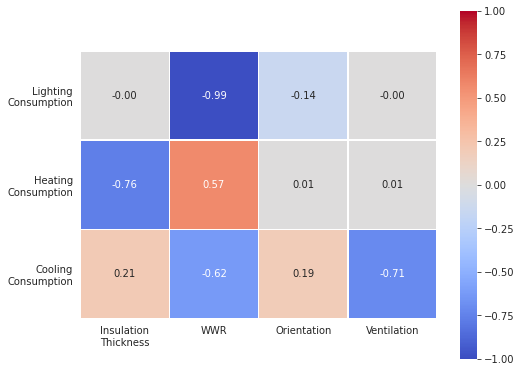

In [11]:
fig=plt.figure(figsize=(8, 8))
temp = outputs.corr()
temp = temp.drop(columns=['Cooling\nConsumption','Heating\nConsumption','Lighting\nConsumption'])
temp = temp.drop(['Ventilation', 'Insulation\nThickness', 'WWR', 'Orientation'])

mask = np.zeros_like(temp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(
        temp, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm',
        square=True, 
        linewidths=.5, 
        annot_kws={"size": 10}, 
        cbar_kws={"shrink": .8},
        vmin=-1,
        vmax=1
    )
    ax.set_ylim(3, 0, .5)
    plt.yticks(rotation=0) 
#     plt.title(f'Correlation among parameters and consumption in {title} configuration')
    plt.savefig(f'../fig/heatmap_{title}.png')